In [161]:
! pip install pyspark setuptools matplotlib seaborn pyarrow


In [162]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat, lit, regexp_replace, regexp_extract, col, desc
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark = SparkSession.builder.appName("Predict Phone Cost").getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxColumnWidth', 1000)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 1000)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

spark

In [163]:
dataset_1 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_1.csv", header=True)
dataset_2 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_2.csv", header=True)
dataset_3 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_3.csv", header=True)
dataset_4 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_4.csv", header=True)

## Подготовка датасетов

In [164]:
# Удаляем столбцы, которые не будем использовать
dataset_1 = dataset_1\
    .withColumn("Phone Name", concat(dataset_1["Brand"], lit(" "), dataset_1["Model"]))\
    .drop("Brand", "Model", "Screen Size")
columns = dataset_1.columns
columns.remove("Phone Name")
columns.insert(0, "Phone Name")
dataset_1 = dataset_1.select(columns)\

# Приводим столбцы к нужному нам виду
dataset_1 = dataset_1\
    .withColumn("Storage", regexp_replace(dataset_1["Storage"], " GB", ""))\
    .withColumn("RAM", regexp_replace(dataset_1["RAM"], " GB", ""))\
    .withColumn("Camera", regexp_extract(dataset_1["Camera"], r"\d+", 0))\

# Приведём столбцы к нужному типу
dataset_1 = dataset_1\
    .withColumn("Storage", dataset_1["Storage"].cast("integer"))\
    .withColumn("RAM", dataset_1["RAM"].cast("integer"))\
    .withColumn("Camera", dataset_1["Camera"].cast("integer"))\
    .withColumn("Battery Capacity", dataset_1["Battery Capacity"].cast("integer"))\
    .withColumn("Price", dataset_1["Price"].cast("integer"))\
    .withColumn("Price", col("Price") * 80)\
    .withColumnRenamed("Battery Capacity", "Battery")

In [165]:
dataset_1.printSchema()

root
 |-- Phone Name: string (nullable = true)
 |-- Storage: integer (nullable = true)
 |-- RAM: integer (nullable = true)
 |-- Camera: integer (nullable = true)
 |-- Battery: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [166]:
# Удаляем лишние столбцы и сокращаем названия
dataset_2 = dataset_2\
    .withColumnRenamed("Brand me", "Phone Name")\
    .withColumnRenamed("ROM", "Storage")\
    .withColumnRenamed("Primary_Cam", "Camera")\
    .withColumnRenamed("Battery_Power", "Battery")\
    .drop("Ratings", "Unnamed: 0", "Mobile_Size", "Selfi_Cam")

# Переопределяем типы у столбцов
dataset_2 = dataset_2\
    .withColumn("RAM", dataset_2["RAM"].cast("integer"))\
    .withColumn("Storage", dataset_2["Storage"].cast("integer"))\
    .withColumn("Camera", dataset_2["Camera"].cast("integer"))\
    .withColumn("Battery", dataset_2["Battery"].cast("integer"))\
    .withColumn("Price", dataset_2["Price"].cast("integer"))

# Создаём удобный порядок столбцов
columns_2 = dataset_2.columns
columns_2.remove("RAM")
columns_2.remove("Storage")
columns_2.insert(1, "Storage")
columns_2.insert(2, "RAM")
dataset_2 = dataset_2.select(columns_2)

In [167]:
dataset_2.printSchema()

root
 |-- Phone Name: string (nullable = true)
 |-- Storage: integer (nullable = true)
 |-- RAM: integer (nullable = true)
 |-- Camera: integer (nullable = true)
 |-- Battery: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [168]:
# Удаляем лишние столбцы
dataset_3 = dataset_3\
    .drop("Rating ?/5", "Number of Ratings", "Processor", "Date of Scraping", "Front Camera")\
    .withColumnRenamed("ROM/Storage", "Storage")\
    .withColumnRenamed("Back/Rare Camera", "Camera")\
    .withColumnRenamed("Back/Rare Camera", "Battery")\
    .withColumnRenamed("Price in INR", "Price")

# Удаляем из строк лишние данные
dataset_3 = dataset_3\
    .withColumn("RAM", regexp_replace(dataset_3["RAM"], " GB RAM", ""))\
    .withColumn("Storage", regexp_replace(dataset_3["Storage"], " GB ROM", ""))\
    .withColumn("Battery", regexp_replace(dataset_3["Battery"], " mAh", ""))\
    .withColumn("Price", regexp_replace(regexp_replace(dataset_3["Price"], "₹", ""), ",", ""))\
    .withColumn("Camera", regexp_extract(dataset_3["Camera"], r"\d+", 0))\

# Меняем местами столбцы для нужного нам порядка
columns_3 = dataset_3.columns
columns_3.remove("RAM")
columns_3.remove("Storage")
columns_3.insert(1, "Storage")
columns_3.insert(2, "RAM")
dataset_3 = dataset_3.select(columns_3)

# Переопределяем типы у столбцов
dataset_3 = dataset_3\
    .withColumn("Storage", dataset_3["Storage"].cast("integer"))\
    .withColumn("RAM", dataset_3["RAM"].cast("integer"))\
    .withColumn("Camera", dataset_3["Camera"].cast("integer"))\
    .withColumn("Battery", dataset_3["Battery"].cast("integer"))\
    .withColumn("Price", (dataset_3["Price"] * 1.1).cast("integer"))


In [169]:
dataset_3.printSchema()

root
 |-- Phone Name: string (nullable = true)
 |-- Storage: integer (nullable = true)
 |-- RAM: integer (nullable = true)
 |-- Camera: integer (nullable = true)
 |-- Battery: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [170]:
columns_4 = ["Name", "Internal storage (GB)", "RAM (MB)", "Rear camera", "Battery capacity (mAh)","Price"]
dataset_4 = dataset_4.select(columns_4)
dataset_4 = dataset_4.withColumnRenamed("Battery capacity (mAh)", "Battery")\
    .withColumnRenamed("RAM (MB)", "RAM")\
    .withColumnRenamed("Internal Storage (GB)", "Storage")\
    .withColumnRenamed("Rear camera", "Camera")\
    .withColumnRenamed("Name", "Phone Name")

dataset_4 = dataset_4.withColumn("RAM", (dataset_4["RAM"] / 1000).cast("integer"))\
    .withColumn("Storage", dataset_4["Storage"].cast("integer"))\
    .withColumn("Camera", dataset_4["Camera"].cast("integer"))\
    .withColumn("Battery", dataset_4["Battery"].cast("integer"))\
    .withColumn("Price", dataset_4["Price"].cast("integer"))

In [171]:
dataset_4

Phone Name,Storage,RAM,Camera,Battery,Price
OnePlus 7T Pro McLaren Edition,256,12,48,4085,58998
Realme X2 Pro,64,6,64,4000,27999
iPhone 11 Pro Max,64,4,12,3969,106900
iPhone 11,64,4,12,3110,62900
LG G8X ThinQ,128,6,12,4000,49990
OnePlus 7T,128,8,48,3800,34930
OnePlus 7T Pro,256,8,48,4085,52990
Samsung Galaxy Note 10+,256,12,12,4300,79699
Asus ROG Phone 2,128,8,48,6000,37999
Xiaomi Redmi K20 Pro,128,6,48,4000,23190


In [172]:
# Объединим теперь наши датасеты в один
dataset_union = dataset_1.union(dataset_2).union(dataset_3).union(dataset_4).dropDuplicates(["Phone Name"]).na.drop()

In [173]:
# Создадим вектор фич для матрицы корреляций
corr_features = [x for x in dataset_union.columns if x != "Phone Name"]
print(corr_features)
corr_assem = VectorAssembler(inputCols=corr_features, outputCol="features")
feature_vector_corr = corr_assem.transform(dataset_union)
feature_vector_corr

['Storage', 'RAM', 'Camera', 'Battery', 'Price']


Phone Name,Storage,RAM,Camera,Battery,Price,features
Oppo F19 Pro+ 5G,128,8,64,4310,31920,"[128.0,8.0,64.0,4310.0,31920.0]"
Xiaomi Redmi Note 10S,128,6,64,5000,18320,"[128.0,6.0,64.0,5000.0,18320.0]"
Motorola Moto G Stylus (2021),128,4,48,4000,23920,"[128.0,4.0,48.0,4000.0,23920.0]"
Nokia 6.2,128,4,16,3500,19920,"[128.0,4.0,16.0,3500.0,19920.0]"
Samsung Galaxy S21+ 5G,256,8,12,4800,79920,"[256.0,8.0,12.0,4800.0,79920.0]"
Realme Narzo 50i,32,2,50,5000,7920,"[32.0,2.0,50.0,5000.0,7920.0]"
Samsung Galaxy A52s 5G,128,6,64,4500,35920,"[128.0,6.0,64.0,4500.0,35920.0]"
Oppo A94 5G,128,8,48,4310,31920,"[128.0,8.0,48.0,4310.0,31920.0]"
Oppo Reno 5 Pro 5G,128,8,64,4350,35920,"[128.0,8.0,64.0,4350.0,35920.0]"
Oppo A94,128,8,48,4310,30320,"[128.0,8.0,48.0,4310.0,30320.0]"


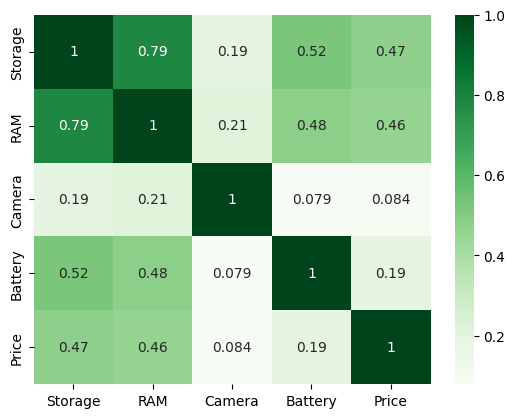

In [174]:
# Построим матрицу корреляций
matrix = Correlation.corr(feature_vector_corr, "features").collect()[0][0].toArray()
sns.heatmap(matrix, xticklabels=corr_features, yticklabels=corr_features, cmap="Greens", annot=True)
plt.show()

##### Видим, что взаимосвязь между "ценой" и "камерой" не такая высокая, но пока что оставим данную фичу для обучения и посмотрим на ошибку модели.

In [175]:
# Создаим список фич в один векторный столбец
features = ["Storage", "RAM", "Camera", "Battery"]
feature = VectorAssembler(inputCols=features, outputCol="features")
feature_vector = feature.transform(dataset_union)

In [184]:
# Разделим датасет на два: тренировочный и тестовый.
train_df, test_df = feature_vector.filter(feature_vector["Price"] < 200000).randomSplit([0.75, 0.25], seed=12345)

In [189]:
train_df

Phone Name,Storage,RAM,Camera,Battery,Price,features
10.or D,16,2,13,3500,4999,"[16.0,2.0,13.0,3500.0]"
10.or D2,16,2,13,3200,4999,"[16.0,2.0,13.0,3200.0]"
10.or E,16,2,13,4000,4999,"[16.0,2.0,13.0,4000.0]"
10.or G,32,3,13,4000,6999,"[32.0,3.0,13.0,4000.0]"
10.or G2,64,4,16,5000,7999,"[64.0,4.0,16.0,5000.0]"
"10A (Black, 64 GB)",64,4,13,5000,10998,"[64.0,4.0,13.0,5000.0]"
Acer Liquid Z630s,32,3,8,4000,7190,"[32.0,3.0,8.0,4000.0]"
Alcatel 1,8,1,5,2000,3499,"[8.0,1.0,5.0,2000.0]"
"Alcatel 1 (Metallic Black, 8 )",8,1,8,2000,4999,"[8.0,1.0,8.0,2000.0]"
"Alcatel 1 (Metallic Blue, 8 )",8,1,8,2000,4999,"[8.0,1.0,8.0,2000.0]"


In [186]:
test_df

Phone Name,Storage,RAM,Camera,Battery,Price,features
Acer Liquid Z530,16,2,8,2420,5750,"[16.0,2.0,8.0,2420.0]"
"Alcatel Idol 4 (Dark Grey, 16 GB)",16,3,13,2610,18698,"[16.0,3.0,13.0,2610.0]"
"Alcatel Onetouch Flash 6042D (Crystal White, 8 GB)",8,1,13,3200,10998,"[8.0,1.0,13.0,3200.0]"
"Alcatel Pixi 4 (6) 4G (Metal Gold, 16 GB)",16,1,8,2580,10448,"[16.0,1.0,8.0,2580.0]"
"Apple iPhone 11 Pro (Gold, 64 )",64,8,35,3500,106600,"[64.0,8.0,35.0,3500.0]"
Apple iPhone 12 Pro Max,128,6,12,3687,87920,"[128.0,6.0,12.0,3687.0]"
Apple iPhone 13 Pro,128,6,12,3095,79920,"[128.0,6.0,12.0,3095.0]"
Apple iPhone 8 Plus,64,3,12,2691,55920,"[64.0,3.0,12.0,2691.0]"
Apple iPhone SE (2nd Gen),64,3,12,1821,31920,"[64.0,3.0,12.0,1821.0]"
Asus ZenFone 3S Max,32,3,13,5000,14999,"[32.0,3.0,13.0,5000.0]"


In [190]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="Price", featuresCol="features")
model = gbt.fit(train_df)
pred = model.transform(test_df)

In [191]:
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")

In [192]:
lr_accuracy = evaluator.evaluate(pred)
lr_accuracy

5555.633624288024

In [193]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 30])\
    .addGrid(gbt.maxDepth, [3])\
    .build()

In [194]:
# crossval = CrossValidator(estimator=gbt,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=evaluator,
#                           numFolds=2)

# cv_model = crossval.fit(train_df)
# cv_model.avgMetrics

Попробуем запустить модель на чистом 4 датасете

In [195]:
dataset_4 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_4.csv", header=True, inferSchema=True)

In [196]:
from pyspark.ml.feature import StringIndexer

touch_indexer = StringIndexer(inputCol="Touchscreen", outputCol="touch_index")
operating_indexer = StringIndexer(inputCol="Operating system", outputCol="os_index")
fg_indexer = StringIndexer(inputCol="4G/ LTE", outputCol="4g_index")

pipeline = Pipeline(stages=[touch_indexer, operating_indexer, fg_indexer])
dataset_4 = pipeline.fit(dataset_4).transform(dataset_4)

In [197]:
dataset_4 = dataset_4\
    .drop("Touchscreen", "Operating system", "Wi-Fi", "Bluetooth", "GPS", "3G", "4G/ LTE", "Brand", "Model", "_c0")\
    .withColumnRenamed("Battery capacity (mAh)", "Battery")\
    .withColumnRenamed("Screen size (inches)", "Screen")\
    .withColumnRenamed("Internal Storage (GB)", "Storage")\
    .withColumnRenamed("Number of SIMs", "SIMs")\
    .withColumn("RAM (MB)", col("RAM (MB)") / 1000)
dataset_4.show(2)

+--------------------+-------+------+------------+------------+---------+--------+-------+-----------+------------+----+-----+-----------+--------+--------+
|                Name|Battery|Screen|Resolution x|Resolution y|Processor|RAM (MB)|Storage|Rear camera|Front camera|SIMs|Price|touch_index|os_index|4g_index|
+--------------------+-------+------+------------+------------+---------+--------+-------+-----------+------------+----+-----+-----------+--------+--------+
|OnePlus 7T Pro Mc...|   4085|  6.67|        1440|        3120|        8|    12.0|  256.0|       48.0|        16.0|   2|58998|        0.0|     0.0|     0.0|
|       Realme X2 Pro|   4000|   6.5|        1080|        2400|        8|     6.0|   64.0|       64.0|        16.0|   2|27999|        0.0|     0.0|     0.0|
+--------------------+-------+------+------------+------------+---------+--------+-------+-----------+------------+----+-----+-----------+--------+--------+
only showing top 2 rows



In [198]:
corr_feat = [x for x in dataset_4.columns if x != "Name"]
corr_vect = VectorAssembler(inputCols=corr_feat, outputCol="features")
corr_vect_feat = corr_vect.transform(dataset_4)
corr_vect_feat

Name,Battery,Screen,Resolution x,Resolution y,Processor,RAM (MB),Storage,Rear camera,Front camera,SIMs,Price,touch_index,os_index,4g_index,features
OnePlus 7T Pro McLaren Edition,4085,6.67,1440,3120,8,12.0,256.0,48.0,16.0,2,58998,0.0,0.0,0.0,"[4085.0,6.67,1440.0,3120.0,8.0,12.0,256.0,48.0,16.0,2.0,58998.0,0.0,0.0,0.0]"
Realme X2 Pro,4000,6.5,1080,2400,8,6.0,64.0,64.0,16.0,2,27999,0.0,0.0,0.0,"[4000.0,6.5,1080.0,2400.0,8.0,6.0,64.0,64.0,16.0,2.0,27999.0,0.0,0.0,0.0]"
iPhone 11 Pro Max,3969,6.5,1242,2688,6,4.0,64.0,12.0,12.0,2,106900,0.0,2.0,0.0,"[3969.0,6.5,1242.0,2688.0,6.0,4.0,64.0,12.0,12.0,2.0,106900.0,0.0,2.0,0.0]"
iPhone 11,3110,6.1,828,1792,6,4.0,64.0,12.0,12.0,2,62900,0.0,2.0,0.0,"[3110.0,6.1,828.0,1792.0,6.0,4.0,64.0,12.0,12.0,2.0,62900.0,0.0,2.0,0.0]"
LG G8X ThinQ,4000,6.4,1080,2340,8,6.0,128.0,12.0,32.0,1,49990,0.0,0.0,1.0,"[4000.0,6.4,1080.0,2340.0,8.0,6.0,128.0,12.0,32.0,1.0,49990.0,0.0,0.0,1.0]"
OnePlus 7T,3800,6.55,1080,2400,8,8.0,128.0,48.0,16.0,2,34930,0.0,0.0,0.0,"[3800.0,6.55,1080.0,2400.0,8.0,8.0,128.0,48.0,16.0,2.0,34930.0,0.0,0.0,0.0]"
OnePlus 7T Pro,4085,6.67,1440,3120,8,8.0,256.0,48.0,16.0,2,52990,0.0,0.0,0.0,"[4085.0,6.67,1440.0,3120.0,8.0,8.0,256.0,48.0,16.0,2.0,52990.0,0.0,0.0,0.0]"
Samsung Galaxy Note 10+,4300,6.8,1440,3040,8,12.0,256.0,12.0,10.0,2,79699,0.0,0.0,0.0,"[4300.0,6.8,1440.0,3040.0,8.0,12.0,256.0,12.0,10.0,2.0,79699.0,0.0,0.0,0.0]"
Asus ROG Phone 2,6000,6.59,1080,2340,8,8.0,128.0,48.0,24.0,1,37999,0.0,0.0,0.0,"[6000.0,6.59,1080.0,2340.0,8.0,8.0,128.0,48.0,24.0,1.0,37999.0,0.0,0.0,0.0]"
Xiaomi Redmi K20 Pro,4000,6.39,1080,2340,8,6.0,128.0,48.0,20.0,2,23190,0.0,0.0,1.0,"[4000.0,6.39,1080.0,2340.0,8.0,6.0,128.0,48.0,20.0,2.0,23190.0,0.0,0.0,1.0]"


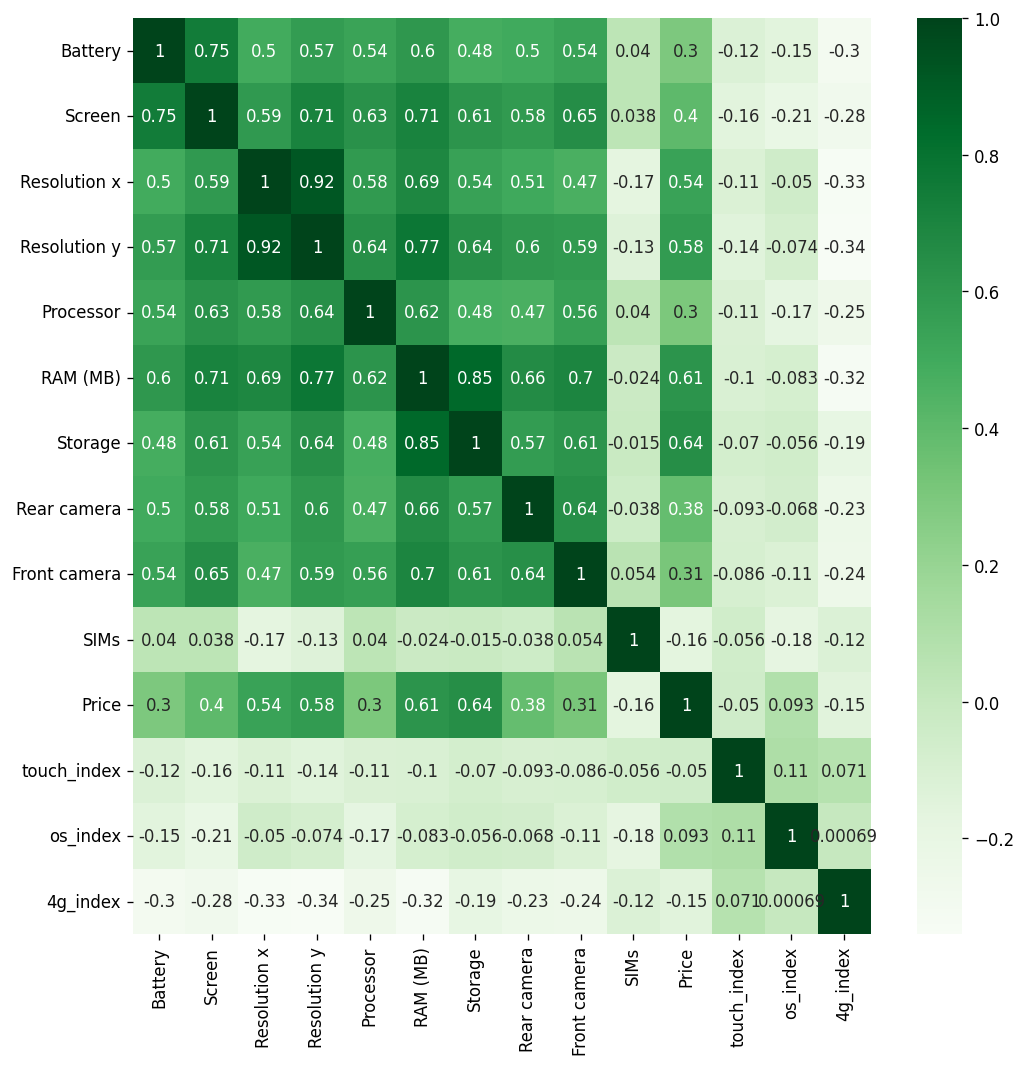

In [199]:
matrix = Correlation.corr(corr_vect_feat, "features").collect()[0][0].toArray()
plt.figure(figsize=(10, 10), dpi=119)
sns.heatmap(matrix, xticklabels=corr_feat, yticklabels=corr_feat, cmap="Greens", annot=True)
plt.show()

In [200]:
features_4 = [x for x in dataset_4.columns if x not in ("Name", "Price")]
features = VectorAssembler(inputCols=features_4, outputCol="features")
data_4 = features.transform(dataset_4)

In [201]:
train_4_df, test_4_df = data_4.filter(col("Price") < 107000).randomSplit([0.75, 0.25], seed=12345)

In [202]:
train_4_df.select("Price").orderBy(col("Price").desc())

Price
106900
92999
88719
83900
77299
74990
74164
73999
73300
69999


In [203]:
test_4_df.select("Price").orderBy(col("Price").desc())

Price
96900
79699
69999
59999
57915
52990
49990
47990
47000
42021


In [204]:
model_4 = gbt.fit(train_4_df)

In [205]:
predict_4 = model_4.transform(test_4_df)
evaluator.evaluate(predict_4)

4138.747896562106